# 2021-04 NSF Training part 2

Outline 



Here are the use cases we’ve collected to be considered for part 2 training:

1. How to use Dimension APIs to feed data to Tableau?
2. Can we input a group of PI identifiers and see how many papers they’ve published together?
3. If we start searching for all the grants that have been awarded by saying CISE in the last 10 years, can we get back a table containing a list of publications and patents citing those grants as funding support?  In other words, the final output table should contain 5 columns: Funding Agency, Grant id (Dimensions), Grant number (Agency), Publication id, Patent id?  In theory, this could generate many records with duplicate publication id and/or patent id as there might be multiple publications and patents to each award, but one could also easy roll-up by grant id, and count from the table, on average, the number of publications and patents of a given award.
4. If we look at publications (that came out in the last 10 years) citing CSE as one of the funders, and from there query both sets of grant ids, and then see if there are any patenting activities associate with those grants, that’d be equally interesting too. 
 
Here is the secondary list nice to go over if time permits:

5. For a given list of NSF awards, how to find out if the awardees have awards from other funders outside NSF?
6. The different agencies (NIH/DOE/NSF) that are listed in publications
7. How to get Altmetrics data through Dimensions APIs, for a given NSF award or publication
8. How to get the number of co-authors on publications, and their details
9. The number of patents


## Couple of reminders

* National Science Foundation is grid.431093.c
* `nsfgrids = pd.read_csv("Dimensions-My-groups-2021-04-07_08-05-49.csv")['ID'].to_list()`



## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are fzamiliar with the *Getting Started* tutorial.


In [22]:
!pip install dimcli --quiet 

import dimcli
from dimcli.utils import *

import json
import sys
import pandas as pd
from IPython.display import Image
from IPython.core.display import HTML

print("==\nLogging in..")

ENDPOINT = "https://app.dimensions.ai"

if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)

dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.9)
Connected to: https://app.dimensions.ai - DSL v1.30
Method: dsl.ini file


### Let's reload the NSF funder group GRIDs 

See Part 1 of this tutorial for more details. 

In [23]:
nsfgrids = pd.read_csv("Dimensions-My-groups-2021-04-07_08-05-49.csv")['ID'].to_list()

def print_grid_info(grids_list):
    data = dsl.query(f"""search organizations where id in {json.dumps(nsfgrids)} return organizations[id+name] limit 500""")
    print("---")
    for n, x in enumerate(data.organizations):
        gridurl = "https://grid.ac/institutes/" + x['id']
        link = f"""<a href="{gridurl}">{gridurl}</a>"""
        print(n, ":", x['name'])
        display(HTML("=> " + link))
        
print_grid_info(nsfgrids)


Returned Organizations: 25 (total = 25)
Time: 0.53s
---
0 : National Science Foundation


1 : Directorate for Biological Sciences


2 : Directorate for Education & Human Resources


3 : Directorate for Computer & Information Science & Engineering


4 : Directorate for Engineering


5 : Directorate for Geosciences


6 : Directorate for Mathematical & Physical Sciences


7 : National Science Board


8 : Office of the Director


9 : Office of Information and Resource Management


10 : Directorate for Social, Behavioral & Economic Sciences


11 : Office of Inspector General


12 : Office of Budget, Finance and Award Management


13 : Office of Polar Programs


14 : Division of Earth Sciences


15 : Division of Chemical, Bioengineering, Environmental, and Transport Systems


16 : Division of Engineering Education & Centers


17 : Division of Mathematical Sciences


18 : Division of Advanced Cyberinfrastructure


19 : Division of Environmental Biology


20 : Division of Graduate Education


21 : Division of Social and Economic Sciences


22 : Division of Materials Research


23 : Division of Civil, Mechanical & Manufacturing Innovation


24 : Division of Ocean Sciences


## 1. How to use Dimension APIs to feed data to Tableau?

It is possible, but this requires some Tableau data-connectors expertise. Some urls: 

* https://www.tableau.com/en-gb/about/blog/2015/8/connect-just-about-any-web-data-new-web-data-connector-42246-0
* https://www.tableau.com/developer/data-connectivity


**TIP**

If you are after real-time integration, [Dimensions on GBQ is more suited](https://docs.dimensions.ai/bigquery/bi-tools-tableau.html). 


## 2. Can we input a group of PI identifiers and see how many papers they’ve published together?



Yes. 
Once you have a list of researchers IDs, the basic query looks like this

In [25]:
%%dsldf

search publications 
 where researchers in ["ur.0712003446.74"] and researchers in ["ur.016320653066.87"]
return publications

Returned Publications: 5 (total = 5)
Time: 0.61s


,id,type,year,title,pages,author_affiliations,volume,issue,journal.id,journal.title
0,pub.1005571175,chapter,2013,Stretching the Capabilities of Energy Harvesti...,399-415,"[[{'raw_affiliation': ['SRI International, 333...",NaN,NaN,NaN,NaN
1,pub.1067966707,article,2012,Dielectric elastomers: Stretching the capabili...,246-253,"[[{'raw_affiliation': ['SRI International, Men...",37,3,jour.1381332,MRS Bulletin
2,pub.1019900398,chapter,2012,From Boots to Buoys: Promises and Challenges o...,67-93,"[[{'raw_affiliation': ['SRI International, 333...",NaN,NaN,NaN,NaN
3,pub.1009376919,proceeding,2011,From boots to buoys: promises and challenges o...,797605-797605-19,[[{'raw_affiliation': ['SRI International (USA...,7976,NaN,jour.1312104,Proceedings of SPIE
4,pub.1050642837,article,2007,Development and Testing of the Mentor Flapping...,1701-1711,"[[{'raw_affiliation': [], 'first_name': 'Patri...",44,5,jour.1123512,Journal of Aircraft


A more real-world situation. 

Let's try to run that for an arbitrary list of researchers. 

The first thing we want to do is to get a full list of papers from those researchers, combined.  

In [26]:
researchers = ["ur.01300627117.45", "ur.01277210601.37", "ur.0712003446.74", "ur.01164503023.84", "ur.01023531107.25", "ur.015315123227.85"]

#
# use `query_iterative` to get up to 50k records
#
allpubs = dsl.query_iterative(f"""
search publications 
    where researchers in {json.dumps(researchers)}
return publications[year+doi+id+researchers] 
""").as_dataframe()

allpubs

Starting iteration with limit=1000 skip=0 ...
0-1000 / 1112 (2.17s)
1000-1112 / 1112 (0.68s)
===
Records extracted: 1112


,doi,year,id,researchers
0,10.1016/j.scib.2020.12.023,2021.0,pub.1133585945,"[{'id': 'ur.010621020445.92', 'last_name': 'Bi..."
1,10.1016/j.joule.2020.12.018,2021.0,pub.1134518778,"[{'id': 'ur.013211577275.92', 'last_name': 'Me..."
2,10.1016/j.compscitech.2021.108677,2021.0,pub.1134846876,"[{'id': 'ur.012127756567.96', 'last_name': 'Wa..."
3,10.1117/12.2587093,2021.0,pub.1136543363,"[{'id': 'ur.016225624463.67', 'last_name': 'Pl..."
4,10.1038/s41586-021-03295-8,2021.0,pub.1136269217,"[{'id': 'ur.016622642113.60', 'last_name': 'Sh..."
...,...,...,...,...
1107,10.1149/1.2124261,1982.0,pub.1053225087,"[{'id': 'ur.01337723522.69', 'last_name': 'Sko..."
1108,10.1088/0031-8949/25/6a/053,1982.0,pub.1058997323,"[{'id': 'ur.01164503023.84', 'last_name': 'Ing..."
1109,10.1080/00268948208072183,1982.0,pub.1029296203,"[{'id': 'ur.01337723522.69', 'last_name': 'Sko..."
1110,10.1016/0040-6090(81)90625-8,1981.0,pub.1036405559,"[{'id': 'ur.01164503023.84', 'last_name': 'Ing..."


Then we are generating a matrix by counting how many times each researcher is a coauthor with any of the researchers in the original list. 

In [27]:

def coauthors_check(res1, res2):
    """Check if res1 & res2 are in the authors list of of a publications, for all publications in our dataframe."""
    count = 0 
    if res1 == res2:
        return count
    for index, row in allpubs.iterrows():
        authors = [el['id'] for el in row['researchers']]
        if res1 in authors and res2 in authors:
            count +=1 
    return count 
    

# run so to check all combinations 

vals = []
for res1 in researchers:
    valsinner = []
    for res2 in researchers:
        result = coauthors_check(res1, res2)
        print(res1, res2, result)
        valsinner += [result]
    vals += [valsinner]
vals 

ur.01300627117.45 ur.01300627117.45 0
ur.01300627117.45 ur.01277210601.37 36
ur.01300627117.45 ur.0712003446.74 0
ur.01300627117.45 ur.01164503023.84 0
ur.01300627117.45 ur.01023531107.25 0
ur.01300627117.45 ur.015315123227.85 0
ur.01277210601.37 ur.01300627117.45 36
ur.01277210601.37 ur.01277210601.37 0
ur.01277210601.37 ur.0712003446.74 17
ur.01277210601.37 ur.01164503023.84 13
ur.01277210601.37 ur.01023531107.25 3
ur.01277210601.37 ur.015315123227.85 0
ur.0712003446.74 ur.01300627117.45 0
ur.0712003446.74 ur.01277210601.37 17
ur.0712003446.74 ur.0712003446.74 0
ur.0712003446.74 ur.01164503023.84 0
ur.0712003446.74 ur.01023531107.25 4
ur.0712003446.74 ur.015315123227.85 4
ur.01164503023.84 ur.01300627117.45 0
ur.01164503023.84 ur.01277210601.37 13
ur.01164503023.84 ur.0712003446.74 0
ur.01164503023.84 ur.01164503023.84 0
ur.01164503023.84 ur.01023531107.25 0
ur.01164503023.84 ur.015315123227.85 0
ur.01023531107.25 ur.01300627117.45 0
ur.01023531107.25 ur.01277210601.37 3
ur.010235311

[[0, 36, 0, 0, 0, 0],
 [36, 0, 17, 13, 3, 0],
 [0, 17, 0, 0, 4, 4],
 [0, 13, 0, 0, 0, 0],
 [0, 3, 4, 0, 0, 0],
 [0, 0, 4, 0, 0, 0]]

Let's display the data as a heatmap

See also this tutorial: [Plot correlation matrix using pandas](https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas/50703596#50703596)

In [6]:
idx = researchers
cols = researchers
df = pd.DataFrame(vals, columns = cols, index = idx)

df.style.background_gradient(cmap ='coolwarm', axis=None)\
        .set_properties(**{'font-size': '20px'})

,ur.01300627117.45,ur.01277210601.37,ur.0712003446.74,ur.01164503023.84,ur.01023531107.25,ur.015315123227.85
ur.01300627117.45,0,36,0,0,0,0
ur.01277210601.37,36,0,17,13,3,0
ur.0712003446.74,0,17,0,0,4,4
ur.01164503023.84,0,13,0,0,0,0
ur.01023531107.25,0,3,4,0,0,0
ur.015315123227.85,0,0,4,0,0,0


## 3. Grants list with associated publications and patents 

> If we start searching for all the grants that have been awarded by saying CISE in the last 10 years, can we get back a table containing a list of publications and patents citing those grants as funding support?  
> In other words, the final output table should contain 5 columns: Funding Agency, Grant id (Dimensions), Grant number (Agency), Publication id, Patent id?  
> In theory, this could generate many records with duplicate publication id and/or patent id as there might be multiple publications and patents to each award, but one could also easy roll-up by grant id, and count from the table, on average, the number of publications and patents of a given award.


### 3.1 From grants to Associated publications

Three main steps

1. Get the list of grants 
2. Get all publications funded by those grants, in bulk
3. Roll up publications by grants 
    
**NOTE** see also this tutorial [Enriching Grants part 2: Adding Publications Information from Dimensions](https://api-lab.dimensions.ai/cookbooks/3-grants/2-grants-enrichment-adding-publications-information.html)    
 

In [28]:
# first let's get those grants 

grants  = dsl.query_iterative("""
search grants 
    where funders in ["grid.457785.c"]
    and start_year >= 2018 
return grants[id+title+grant_number+start_year+funding_org_name] 
""").as_dataframe()

grants.head(5)

Starting iteration with limit=1000 skip=0 ...
0-1000 / 6967 (0.67s)
1000-2000 / 6967 (0.67s)
2000-3000 / 6967 (0.69s)
3000-4000 / 6967 (0.57s)
4000-5000 / 6967 (0.66s)
5000-6000 / 6967 (0.66s)
6000-6967 / 6967 (0.60s)
===
Records extracted: 6967


,grant_number,funding_org_name,start_year,title,id
0,2040926,Directorate for Computer & Information Science...,2021,FAI: Quantifying and Mitigating Disparities in...,grant.9605613
1,2044516,Directorate for Computer & Information Science...,2021,CAREER: Data-Driven Wireless Networking Design...,grant.9620903
2,2047516,Directorate for Computer & Information Science...,2021,CAREER: Achieving Real-Time Machine Learning w...,grant.9605878
3,2047623,Directorate for Computer & Information Science...,2021,CAREER: Black-Box Learning of Web Application ...,grant.9621098
4,2051621,Directorate for Computer & Information Science...,2021,SaTC: CORE: Small: Automatic Exploits Detectio...,grant.9606024


#### Extracting publications from a long grants list 

> See also [Working with lists in the Dimensions API](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html)

In [29]:
# second, let's get publications 
# each query can take ~300 grants at a time, so we have to 'chunk' the grants list 

from tqdm.notebook import tqdm as progressbar
grantsids = grants['id'].to_list()


#
# the main query
#
q = """search publications
          where supporting_grant_ids in {}
       return publications[title+doi+year+supporting_grant_ids+funders]"""

#
# let's loop through all grants IDs in chunks and query Dimensions
#
results = []
for chunk in progressbar(list(chunks_of(list(grantsids), 200))):
    data = dsl.query_iterative(q.format(json.dumps(chunk)), verbose=False)
    results += data.publications
    time.sleep(1)

#
# put the data into a dataframe, remove duplicates and save
#
pubs = pd.DataFrame().from_dict(results)
print("Publications found: ", len(pubs))
pubs.drop_duplicates(subset='doi', inplace=True)
print("Unique publications found: ", len(pubs))
# turning lists into strings to ensure compatibility with CSV loaded data
# see also: https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list
pubs['supporting_grant_ids'] = pubs['supporting_grant_ids'].apply(lambda x: ','.join(map(str, x)))

#
# preview
#
pubs.head(5)


Publications found:  14926
Unique publications found:  12104


,year,supporting_grant_ids,title,doi,funders
0,2021,"grant.9621109,grant.7028950",SARS-CoV-2 transmission dynamics in Belarus re...,10.1101/2021.04.13.21255404,"[{'id': 'grid.457785.c', 'country_name': 'Unit..."
1,2021,"grant.9214869,grant.9605585,grant.9383405",UAV-Assisted Communication in Remote Disaster ...,10.1109/ojcoms.2021.3067001,"[{'id': 'grid.457810.f', 'country_name': 'Unit..."
2,2021,"grant.9606039,grant.5544810",Beyond the CPU: Side Channel Attacks on GPUs,10.1109/mdat.2021.3063359,"[{'id': 'grid.457785.c', 'country_name': 'Unit..."
3,2021,"grant.6932729,grant.9621005,grant.5540310,gran...",A Generalized Framework for Preserving Both Pr...,10.1109/tkde.2021.3078099,"[{'id': 'grid.457785.c', 'country_name': 'Unit..."
4,2021,grant.9621063,Towards understanding the design of bodily int...,10.1016/j.ijhcs.2021.102643,"[{'id': 'grid.457785.c', 'latitude': 38.88058,..."


#### Grouping publications by grant and enriching the original list 

In [30]:
def pubs_for_grantid(grantid):
  global pubs
  return pubs[pubs['supporting_grant_ids'].str.contains(grantid)]

l = []
for x in progressbar(grantsids):
  l.append(len(pubs_for_grantid(x)))
grants['pubs'] = l

In [32]:
grants.sort_values("pubs", ascending=False).head(10)

,grant_number,funding_org_name,start_year,title,id,pubs
4152,1908308,Directorate for Computer & Information Science...,2019,NSF-BSF:CIF: Small: A Unified View of Estimati...,grant.8523175,132
6224,1763325,Directorate for Computer & Information Science...,2018,III: Medium: Collaborative Research: An Extens...,grant.7569573,117
6759,1757533,Directorate for Computer & Information Science...,2018,REU Site: Research Experiences in Pervasive Co...,grant.7147675,95
5483,1828363,Directorate for Computer & Information Science...,2018,MRI: Development of an Information Assurance a...,grant.7734747,78
5238,1824440,Directorate for Computer & Information Science...,2018,SpecEES: Collaborative Research: Study of the ...,grant.7734329,75
3470,1930941,Directorate for Computer & Information Science...,2019,SaTC: CORE: Small: Collaborative: Learning Dyn...,grant.8567892,73
3133,1909323,Directorate for Computer & Information Science...,2019,III: Small: Exploiting the Massive User Genera...,grant.8541455,73
5923,1801925,Directorate for Computer & Information Science...,2018,NeTS: Medium: Collaborative Research: Riding t...,grant.7703426,68
6948,1741277,Directorate for Computer & Information Science...,2018,BIGDATA: F: Collaborative Research: Acquisitio...,grant.7057783,68
5762,1818253,Directorate for Computer & Information Science...,2018,Computation for the Endless Frontier,grant.7733371,57


### 3.2 Steps for patents 

Similar approach

1. Get all patents linked to grants, in bulk
2. Roll up patents by grant
    
    
See how it's done here [Enriching Grants part 3: adding related Patents and Clinical Trials data](https://api-lab.dimensions.ai/cookbooks/3-grants/3-grants-enrichment-adding-patents-cltrials-information.html)


## 4. If we look at publications (that came out in the last 10 years) citing CSE..

> as one of the funders, and from there query both sets of grant ids, and then see if there are any patenting activities 


### Approach:

1. Extract all grants IDs from the publications list (this will include both NSF and non NSF funders) 
2. Repeat the patents from grants extraction, as above



In [33]:
grants_from_pubs = set()

for group in pubs['supporting_grant_ids'].to_list():
    grants_from_pubs.update(group.split(","))

unknown_grants =  grants_from_pubs - set(grantsids) 

print("Total grants: ", len(grants_from_pubs)) 
print("Original NSF grants list: ", len(set(grantsids)))
print("Overlap: ", len(grants_from_pubs & set(grantsids)))

Total grants:  10500
Original NSF grants list:  6967
Overlap:  3444


NOTE A lot of grants turned out to be funded **also** by other NSF grants (we didn't have in our original list). 

So we have have a quick check (using only the first 500 grants) of who are the other funders using this query that excludes NSF GRID IDs: 

In [36]:
funders_non_nsf_sample = dsl.query(f"""

search grants 
    where id in {json.dumps(list(unknown_grants)[:500])} 
    not funders in {json.dumps(nsfgrids)}
return funders

""").as_dataframe()
funders_non_nsf_sample.head(5)

Returned Funders: 20
Time: 1.25s


,id,count,city_name,longitude,name,latitude,types,acronym,linkout,country_name,state_name
0,grid.419696.5,83,Beijing,116.339830,National Natural Science Foundation of China,40.005177,[Government],NSFC,[http://www.nsfc.gov.cn/publish/portal1/],China,NaN
1,grid.280785.0,14,Bethesda,-77.099380,National Institute of General Medical Sciences,38.997833,[Facility],NIGMS,[http://www.nigms.nih.gov/Pages/default.aspx],United States,Maryland
2,grid.416868.5,9,Bethesda,-77.104570,National Institute of Mental Health,39.003693,[Facility],NIMH,[https://www.nimh.nih.gov/index.shtml],United States,Maryland
3,grid.419681.3,9,Bethesda,-77.111830,National Institute of Allergy and Infectious D...,39.066647,[Facility],NIAID,[http://www.niaid.nih.gov/Pages/default.aspx],United States,Maryland
4,grid.452896.4,9,Brussels,4.359973,European Research Council,50.856167,[Government],ERC,[http://erc.europa.eu/],Belgium,NaN


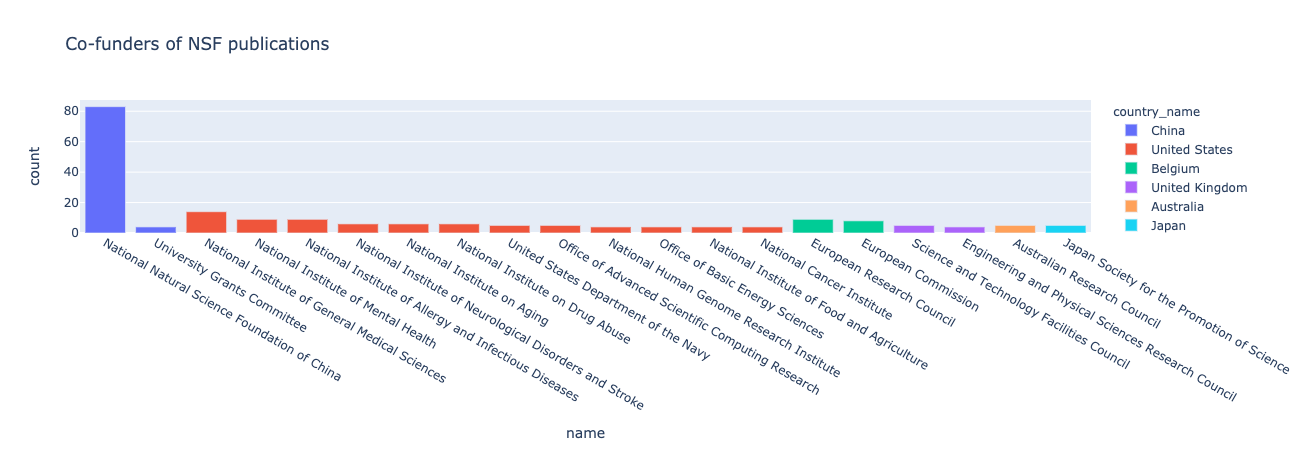

In [35]:
import plotly.express as px

px.bar(funders_non_nsf_sample,
       x="name", y="count",
       color="country_name",
       title=f"Co-funders of NSF publications")




## 5. For a given list of NSF awards, how to find out if the awardees have awards from other funders outside NSF?


### Approach: Three steps 

* first get a list of researchers linked to the NSF awards 
* second get all awards for those researchers
* third, keep only the non-NSF awards 

In [37]:
grants  = dsl.query_iterative("""
search grants 
    where funders in ["grid.457785.c"]
    and start_year >= 2020 
return grants[id+title+grant_number+researchers] 
""").as_dataframe()

grants.head(5)

Starting iteration with limit=1000 skip=0 ...
0-1000 / 2554 (1.86s)
1000-2000 / 2554 (1.95s)
2000-2554 / 2554 (0.85s)
===
Records extracted: 2554


,grant_number,id,title,researchers
0,2040926,grant.9605613,FAI: Quantifying and Mitigating Disparities in...,"[{'id': 'ur.010326200354.06', 'last_name': 'Ne..."
1,2044516,grant.9620903,CAREER: Data-Driven Wireless Networking Design...,"[{'id': 'ur.010770732005.11', 'last_name': 'Lu..."
2,2047516,grant.9605878,CAREER: Achieving Real-Time Machine Learning w...,"[{'id': 'ur.014307500035.17', 'last_name': 'Re..."
3,2047623,grant.9621098,CAREER: Black-Box Learning of Web Application ...,"[{'id': 'ur.010636756673.83', 'last_name': 'Ma..."
4,2051621,grant.9606024,SaTC: CORE: Small: Automatic Exploits Detectio...,"[{'id': 'ur.07734074503.42', 'last_name': 'Meh..."


In [38]:
# ignore grants with no researchers info
grants.dropna(subset=['researchers'], inplace=True)

# get the IDS only
researchers = set()

for index, row in grants.iterrows():
    res = [el['id'] for el in row['researchers']]
    researchers.update(res)

print("Unique researchers: ", len(researchers))

Unique researchers:  3838


In [39]:
#
# A LOOPED EXTRACTION 
#

#
# the main query
#
q = """search grants
          where start_year >= 2020 
          not funders in {}
          and researchers in {}
       return grants[basics+researchers]"""

#
# let's loop through all researcher IDs in chunks and query Dimensions
#
results = []
for chunk in progressbar(list(chunks_of(list(researchers), 200))):
    data = dsl.query_iterative(q.format(json.dumps(nsfgrids), json.dumps(chunk)), verbose=False)
    results += data.grants
    time.sleep(1)

#
# put the data into a dataframe, remove duplicates and save
#
new_grants = pd.DataFrame().from_dict(results)
print("Grants found: ", len(new_grants))
new_grants.drop_duplicates(subset='id', inplace=True)
print("Unique Grants found: ", len(new_grants))



Grants found:  125
Unique Grants found:  124


In [40]:
new_grants['funding_org_name'].value_counts()[:10]

United States Department of the Navy                           37
National Natural Science Foundation of China                    9
National Institute of Food and Agriculture                      7
National Institute of General Medical Sciences                  7
National Institute of Biomedical Imaging and Bioengineering     6
German Research Foundation                                      4
Office of Advanced Scientific Computing Research                4
United States Army                                              4
National Institute on Aging                                     4
National Cancer Institute                                       3
Name: funding_org_name, dtype: int64

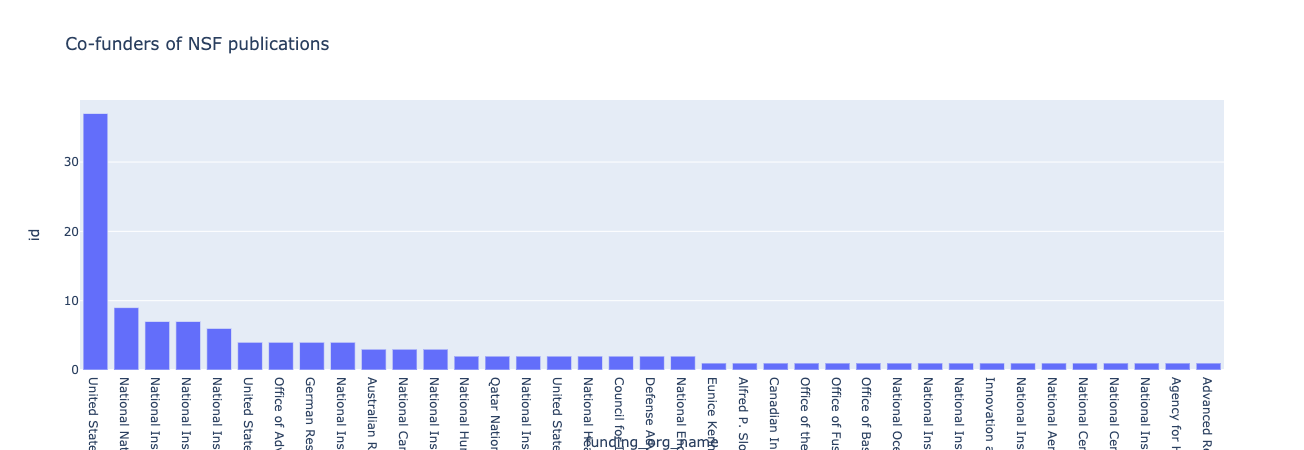

In [41]:
px.bar(new_grants.groupby('funding_org_name', as_index=False).count().sort_values('id', ascending=False),
       x="funding_org_name", y="id",
       title=f"Co-funders of NSF publications")


## 6. The different agencies (NIH/DOE/NSF) that are listed in publications


### Approach 

1. Get publications 'funders' as GRID identifiers
2. Segment funders by agencies (= groups of GRID IDs)

NOTE: Dimensions allows to export list of GRID IDs that correspond to agencies, see https://app.dimensions.ai/browse/facet-filter-groups/publication


## 7. How to get Altmetrics data through Dimensions APIs, for a given NSF award or publication


That cannot be done using the Dimensions API only, as it returns one single value (the Altmetric Score) for a publication `altmetric` field. 

One has to go through the [Altmetric API](http://api.altmetric.com/). 



## 8. How to get the number of co-authors on publications, and their details

* use the `authors` field and `authors_count` to eliminate single authors queries
* use `unnest` to get back one row per author (so easier to analyse the data) 



In [19]:
%%dsldf 

search publications 
    where authors_count > 2 
    and funders in ["grid.457785.c"]
return publications[id+unnest(authors)]

Returned objects: 100 (total publications= 104931)
Time: 24.28s


,id,authors.first_name,authors.last_name,authors.corresponding,authors.orcid,authors.affiliations
0,pub.1137656396,Jin,Yan,True,,"[{'raw_affiliation': 'Department of Civil, Con..."
1,pub.1137656396,Simon,Laflamme,,,[{'raw_affiliation': 'Department of Electrical...
2,pub.1137656396,Jonathan,Hong,,,[{'raw_affiliation': 'Applied Research Associa...
3,pub.1137656396,Jacob,Dodson,,,"[{'name': 'Air Force Research Laboratory, Muni..."
4,pub.1136335824,Vaibhav,Singh,,,[{'raw_affiliation': 'Carnegie Mellon Universi...
...,...,...,...,...,...,...
95,pub.1136742130,Mujdat,Cetin,,['0000-0002-9824-1229'],[{'raw_affiliation': 'Dept. of Electrical and ...
96,pub.1136474201,Jackson,Abascal,,,[{'raw_affiliation': 'Computer Science Departm...
97,pub.1136474201,Lane A.,Hemaspaandra,True,['0000-0003-0659-5204'],[{'raw_affiliation': 'Department of Computer S...
98,pub.1136474201,Shir,Maimon,,,[{'raw_affiliation': 'Department of Computer S...


## 9. The number of patents linked to NSF awards

Same as point 3 above .. see [Enriching Grants part 3: adding related Patents and Clinical Trials data](https://api-lab.dimensions.ai/cookbooks/3-grants/3-grants-enrichment-adding-patents-cltrials-information.html)